<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/YF%20RL%20(2)%20(1)%20(19)%20test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf_agents[reverb]


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip install yfinance


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import tracemalloc

import tensorflow_probability as tfp

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Concatenate, GaussianNoise
from tensorflow.keras.regularizers import l2

from tf_agents.networks import network
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.environments import py_environment, tf_py_environment, utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import trajectory, time_step as ts
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.policies.boltzmann_policy import BoltzmannPolicy
from tf_agents.policies import tf_policy
from tf_agents.utils import common

2023-10-22 23:14:30.660686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
BATCH_SIZE = 64 # @param {type:"integer"}
EVAL_EPISODES = 3 # @param {type:"integer"}
NUMBER_EPISODES = 10000000000 # @param {type:"integer"}
COLLECTION_STEPS = 1 # @param {type:"integer"}
EVAL_INTERVAL =  500 # @param {type:"integer"}

### <font color='purple'><center>**-------------------Create Data-------------------**</font>

In [5]:
end_date = datetime.now()
start_date = end_date - timedelta(days=729)

tickers = [
    'EURUSD=X', 'USDEUR=X',  # Euro/US Dollar
    'USDJPY=X', 'JPYUSD=X',  # US Dollar/Japanese Yen
    'GBPUSD=X', 'USDGBP=X',  # British Pound/US Dollar
    'USDCHF=X', 'CHFUSD=X',  # US Dollar/Swiss Franc
    'AUDUSD=X', 'USDAUD=X',  # Australian Dollar/US Dollar
    'USDCAD=X', 'CADUSD=X',  # US Dollar/Canadian Dollar
    'NZDUSD=X', 'USDNZD=X',  # New Zealand Dollar/US Dollar
]

data_list = []
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval='1h')
    data_list.append(data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
def create_data(raw_data, window_size):
    High = raw_data['High'].to_numpy()
    Close = raw_data['Close'].to_numpy()
    Low = raw_data['Low'].to_numpy()
    Std = np.std(np.diff(Close))
    Close_Diff = np.diff(Close)/Std
    High_Adj = (High[1:]-Close[1:])/Std
    Low_Adj = (Close[1:]-Low[1:])/Std

    stack = np.stack((Close_Diff, High_Adj, Low_Adj), axis=1)

    window_view = np.lib.stride_tricks.sliding_window_view(stack, (window_size,),axis=0)

    Forex_Data = window_view[:-1]
    Forex_Data = Forex_Data.astype('float32')
    target = Close_Diff[window_size:]

    return Forex_Data, target


In [7]:
window_list = []
target_list = []
for data in data_list:
    window, target =  create_data(data, 50)
    window_list.append(window)
    target_list.append(target)


### <font color='red'><center>**-------------------Create Environment-------------------**</font>

In [8]:
def custom_formatter(x):
  return f'{x:.4f}'

def test_environment(env, num_steps):
    # Reset the environment
    observation = env.reset()

    # Get the upper bound of the action range
    action_spec = env.action_spec().maximum

    # Loop through the time steps and take random actions
    for _ in range(num_steps):
        # Select a random action from the range of valid values
        action = np.random.randint(0, action_spec)

        # Execute the action and get the next observation, reward, done, and info
        observation, reward, done, info = env.step(action)

        # Print the current time step
        np.set_printoptions(formatter={'float_kind':custom_formatter})
        print(action,"{:.4f}".format(reward),info[1])

In [10]:
def SortinoRatio(df, T):
    """Calculates the Sortino ratio from univariate excess returns.

    Args:
        df ([float]): The dataframe or pandas series of univariate excess returns.
        T ([integer]): The targeted return.
    """

    # Check if there are less than two numbers in the array or no downside returns
    if len(df) < 2:
        return -1
    if np.all(df >= T):
        return 0

    #downside deviation:
    temp = np.minimum(0, df - T)**2
    temp_expectation = np.mean(temp)
    downside_dev = np.sqrt(temp_expectation)

    #Sortino ratio:
    sortino_ratio = np.mean(df - T) / downside_dev

    return(sortino_ratio)

In [606]:
def calculate_downside_deviation(returns, threshold=0.02):
    """
    Calculate the downside deviation of a numpy array of returns.

    Parameters:
    returns (numpy.ndarray): A numpy array of returns.
    MAR (float): The minimum acceptable return. Default is 0.02.

    Returns:
    float: The downside deviation.
    """
    # Check if the array is empty
    if returns.size == 0:
        return 0

    # Calculate downside returns
    downside_returns = np.where(returns < threshold, returns - threshold, 0)

    # Calculate downside deviation
    downside_deviation = np.std(downside_returns)

    return -downside_deviation

In [607]:
def mean_of_negatives(arr, threshold=0):
    """
    Calculate the mean of the negative returns of a numpy array.

    Parameters:
    arr (numpy.ndarray): A numpy array of returns.
    threshold (float): The minimum acceptable return. Default is 0.

    Returns:
    float: The mean of the negative returns.
    """
    # Check if the array is empty
    if arr.size == 0:
        return 0

    # Calculate the negative returns
    negative_returns = np.where(arr < threshold, arr - threshold, 0)

    # Check if there are any negative returns
    if not np.any(negative_returns < 0):
        return 0

    # Select only the negative numbers
    negatives = negative_returns[negative_returns < 0]

    # Calculate the mean of the negative numbers
    mean = np.mean(negatives)

    return mean

In [608]:
look_ahead_steps = 4

#Define the parameters
max_reward_per_step = 1
discount_factor = 1-1/look_ahead_steps
num_steps = 48

# Calculate the maximum Q-value per step
max_q_value_per_step = max_reward_per_step * (1 - discount_factor**num_steps) / (1 - discount_factor)
discount_factor = round(discount_factor,3)
print(discount_factor)
print(max_q_value_per_step)

0.75
3.9999959728237764


In [1517]:
start = 1
epi_length = 48
class TradingEnv(py_environment.PyEnvironment):

  def __init__(self):
    global start
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int64, minimum=0, maximum=3, name='action')

    self._observation_spec = (
        array_spec.BoundedArraySpec(shape=(3,50), dtype=np.float32, name='observation1'),
        array_spec.BoundedArraySpec(shape=(2,), dtype=np.float32, name='observation2')
    )

    self._count = np.random.randint(1,10000)#startstart
    self._ticker = np.random.randint(0,len(window_list))

    self._max_ep_len = self._count + epi_length
    self._scaler = np.sum(np.absolute(target_list[self._ticker][self._count:self._max_ep_len]))
    self._state = (window_list[self._ticker][self._count-1], np.array([0,0], dtype=np.float32))
    self._episode_ended = False
    self._trade_info = {'value': 0,'direction': 0}
    self._balance = np.array([])
    self._new = False


  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def get_balance(self):
    return self._balance


  def _reset(self):
    global start
    self._count = np.random.randint(1,10000)#start
    self._ticker = np.random.randint(0,len(window_list))
    self._max_ep_len = self._count + epi_length
    self._scaler = np.sum(np.absolute(target_list[self._ticker][self._count:self._max_ep_len]))
    self._state = (window_list[self._ticker][self._count-1], np.array([0,0], dtype=np.float32))
    self._episode_ended = False
    self._trade_info = {'value': 0,'direction': 0}
    self._balance = np.array([])
    self._new = False


    return ts.restart(self._state)

  def _step(self, action):
    global start

    if self._episode_ended:
      return self.reset()

    profit = 0
    reward = 0
    fee = 0
    cur_target = target_list[self._ticker][self._count]
    new_action = False


    if action == 0:
        profit = self._trade_info['value']
        new_action = True 
        reward = cur_target
        fee = .1
        self._trade_info['value'] = cur_target
        self._trade_info['direction'] = 1
    elif action == 1:
        profit = self._trade_info['value']
        new_action = True
        reward = -cur_target
        fee = .1
        self._trade_info['value'] = -cur_target
        self._trade_info['direction'] = -1
    elif action == 2:
        self._trade_info['value'] += cur_target*self._trade_info['direction']
        reward = cur_target*self._trade_info['direction']
    else:
        profit = self._trade_info['value']
        reward = -1 if self._trade_info['value'] == 0 else 0
        self._trade_info['value'] = 0
        self._trade_info['direction'] = 0






    trade_array = np.array([self._trade_info['value'],self._trade_info['direction']], dtype=np.float32)


    self._state = (window_list[self._ticker][self._count], trade_array)

    if profit != 0:
        #reward = profit
        self._balance = np.append(self._balance,profit)
        
    reward -= fee
    
    max_reached = self._count >= self._max_ep_len

    if max_reached and self._trade_info['value'] == 0 or max_reached and new_action:
        if self._trade_info['value'] < 0:       
            self._balance = np.append(self._balance,self._trade_info['value'])
        self._episode_ended = True
    elif self._count >= self._max_ep_len + 100:
        if self._trade_info['value'] < 0:       
            self._balance = np.append(self._balance,self._trade_info['value'])
        self._episode_ended = True

    self._count += 1 

    if self._episode_ended:
      reward = calculate_downside_deviation(self._balance,-.5)
      return ts.termination(self._state, reward=reward)
    else:
      return ts.transition(self._state, reward=reward, discount=discount_factor)



env = TradingEnv()
utils.validate_py_environment(env, episodes=2)

print('Observation Spec:')
print(env.time_step_spec().observation)

print('Reward Spec:')
print(env.time_step_spec().reward)

print('Action Spec:')
print(env.action_spec())

train_env = tf_py_environment.TFPyEnvironment(env)
evaluation_env = tf_py_environment.TFPyEnvironment(env)

Observation Spec:
(BoundedArraySpec(shape=(3, 50), dtype=dtype('float32'), name='observation1', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38), BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name='observation2', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38))
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In [1518]:
test_environment(env,100)

2 0.0000 [0.0000 0.0000]
0 0.8808 [0.9808 1.0000]
1 0.9167 [1.0167 -1.0000]
2 0.6119 [1.6286 -1.0000]
2 -0.3310 [1.2976 -1.0000]
0 -1.6311 [-1.5311 1.0000]
2 0.0718 [-1.4593 1.0000]
1 -0.7464 [-0.6464 -1.0000]
1 -0.3660 [-0.2660 -1.0000]
1 0.5683 [0.6683 -1.0000]
1 -0.1718 [-0.0718 -1.0000]
2 -0.7907 [-0.8625 -1.0000]
1 0.2595 [0.3595 -1.0000]
0 -0.6461 [-0.5461 1.0000]
1 -0.0713 [0.0287 -1.0000]
0 -0.1360 [-0.0360 1.0000]
2 -0.4234 [-0.4593 1.0000]
0 -0.2650 [-0.1650 1.0000]
2 1.0481 [0.8832 1.0000]
0 0.5329 [0.6329 1.0000]
2 0.6696 [1.3024 1.0000]
2 -0.7919 [0.5105 1.0000]
2 1.0154 [1.5259 1.0000]
0 -9.4123 [-9.3123 1.0000]
0 1.6576 [1.7576 1.0000]
0 1.3434 [1.4434 1.0000]
1 -9.6184 [-9.5184 -1.0000]
1 0.8645 [0.9645 -1.0000]
1 -3.5969 [-3.4969 -1.0000]
2 0.9476 [-2.5493 -1.0000]
0 -2.1781 [-2.0781 1.0000]
2 0.1233 [-1.9548 1.0000]
0 0.1249 [0.2249 1.0000]
0 0.3211 [0.4211 1.0000]
1 1.4952 [1.5952 -1.0000]
2 0.0361 [1.6313 -1.0000]
2 -2.8674 [-1.2361 -1.0000]
1 -0.1146 [-0.0146 -1.00

### <font color='blue'><center>**-------------------Create Network-------------------**</font>

In [1519]:
class CustomQNetwork(network.Network):
    def __init__(self, input_tensor_spec, action_spec, name='CustomQNetwork'):
        super(CustomQNetwork, self).__init__(input_tensor_spec=input_tensor_spec,
                                             state_spec=(),
                                             name=name)
        # Define your custom layers and architecture here
        self.LSTM1 = LSTM(units=200, activation='gelu', return_sequences=True)
        self.LSTM2 = LSTM(units=10, activation='gelu', return_sequences=False)
        self.BatchNorm1 = BatchNormalization()
        self.Concat = Concatenate()
        self.Dense1 = Dense(10,activation='gelu')
        self.BatchNorm2 = BatchNormalization()
        self.Dense2 = Dense(200,activation='gelu')
        self.BatchNorm3 = BatchNormalization()
        self.q_values_layer = Dense(action_spec.maximum - action_spec.minimum + 1,
                                                    activation=None)
        self.gaussian_noise_layer = GaussianNoise(stddev=.2)  # Add Gaussian noise with stddev=0.2

    def call(self, observation, step_type=None, network_state=(), training=False):
        # Split the observation into two arrays
        observation1, observation2 = observation

        if training:
            observation1 = self.gaussian_noise_layer(observation1)

        x = self.LSTM1(observation1)
        x = self.LSTM2(x)
        x = self.BatchNorm1(x)
        x = self.Concat([x,observation2])
        x = self.Dense1(x)
        x = self.BatchNorm2(x)
        x = self.Dense2(x)
        x = self.BatchNorm3(x)
        q_values = self.q_values_layer(x)
        return q_values, network_state

In [1520]:
class CategoricalQNetwork(network.Network):
    def __init__(self, input_tensor_spec, action_spec, num_atoms=51, preprocessing_layers=None,
                 preprocessing_combiner=None, conv_layer_params=None, fc_layer_params=None,
                 activation_fn=tf.nn.relu, name='CategoricalQNetwork'):
        super(CategoricalQNetwork, self).__init__(input_tensor_spec=input_tensor_spec,
                                                  state_spec=(),
                                                  name=name)
        # Check if action_spec is a BoundedTensorSpec
        if not isinstance(action_spec, tensor_spec.BoundedTensorSpec):
            raise TypeError('action_spec must be a BoundedTensorSpec. Got: %s' % (action_spec,))

        self._num_actions = action_spec.maximum - action_spec.minimum + 1
        self._num_atoms = num_atoms

        # Create a BoundedTensorSpec for the q_network action
        q_network_action_spec = tensor_spec.BoundedTensorSpec((), tf.int32,
                                                              minimum=0,
                                                              maximum=self._num_actions * num_atoms - 1)

        # Create the q_network
        self._q_network = CustomQNetwork(input_tensor_spec=input_tensor_spec,
                                             action_spec=q_network_action_spec,
                                             )
    def call(self, observation, step_type=None, network_state=(), training=False):
        logits, network_state = self._q_network(observation, step_type, network_state, training=training)
        logits = tf.reshape(logits, [-1, self._num_actions, self._num_atoms])
        return logits, network_state
    @property
    def num_atoms(self):
        return self._num_atoms

In [1521]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()
num_atoms = 51
custom_network = CategoricalQNetwork(observation_spec,action_spec, num_atoms)

In [1522]:
EPSILON_INIT = .5
EPSILON_MIN = 0.1
EPSILON_DECAY_STEPS = 2e5


# Define the epsilon decay function
def epsilon_decay(global_step):
    epsilon = EPSILON_INIT - (EPSILON_INIT - EPSILON_MIN) * tf.minimum(1.0, tf.cast(global_step, tf.float32) / EPSILON_DECAY_STEPS)
    return epsilon
train_env

In [1523]:
min_q = -3.7
max_q = 7
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)
global_step = tf.Variable(0, name='global_step', trainable=False)
train_step_counter = tf.Variable(0)

C51_agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=custom_network,
    optimizer=optimizer,
    min_q_value=min_q,
    max_q_value=max_q,
    epsilon_greedy=None,
    n_step_update=2,
    boltzmann_temperature=.8,
    target_update_tau=.0001,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=1,
    train_step_counter=train_step_counter)
C51_agent.initialize()

### <font color='green'><center>**-------------------Create Replay Buffer And Training Loop-------------------**</font>

In [1524]:
def timestamp_data(environment, policy, replay_buffer):
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        timestamp_trajectory = trajectory.from_transition(time_step, action_step, next_time_step)
        replay_buffer.add_batch(timestamp_trajectory)

In [1525]:
replay_buffer.clear()
#define replay buffer
replay_buffer = TFUniformReplayBuffer(
            data_spec=C51_agent.collect_data_spec,
            batch_size=train_env.batch_size,
            max_length=50000)

#random policy for filling buffer
random_policy = RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

train_env.reset()
#fill replay buffer
for _ in range(1000):
    timestamp_data(train_env, random_policy,replay_buffer)

#create dataset from buffer
dataset = replay_buffer.as_dataset(
            num_parallel_calls=tf.data.AUTOTUNE,
            sample_batch_size=BATCH_SIZE,
            num_steps=2).prefetch(tf.data.AUTOTUNE)

iterator = iter(dataset)


In [1526]:
#define checkpointer

checkpoint_dir = '/tmp/MODEL2'

train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=C51_agent,
        policy=C51_agent.policy,
        replay_buffer=replay_buffer,
        global_step=global_step
    )


In [1527]:
train_checkpointer.initialize_or_restore(checkpoint_dir)

In [1528]:
from tf_agents.trajectories import policy_step
class CustomPolicy(tf_policy.TFPolicy):
    def __init__(self, time_step_spec, action_spec,network,agent, name=None):
        super(CustomPolicy, self).__init__(
            time_step_spec,
            action_spec,
            policy_state_spec=(),
            clip=False,
            name=name)
        self._network = network
        self._agent = agent
        self._epsilon = epsilon_decay(global_step)

    def _action(self, time_step, policy_state=(), seed=None):
        # Define your action logic here
        self._epsilon = epsilon_decay(global_step)

        if tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32) < .3:
            Distribution = self._network(time_step.observation)[0][0]
            tensors = []

            highest_index = Entropy(Distribution)
            action = tf.cast(highest_index,tf.int64)
            action = tf.reshape(action,(1,))
        else:
            action = self._agent.policy.action(time_step)[0]
            
            
            
            
        return policy_step.PolicyStep(action, state=policy_state, info=())

    def _get_initial_state(self, batch_size=None):
        # Define your initial state logic here
        return ()
    
time_step_spec = train_env.time_step_spec()
action_spec = train_env.action_spec()
print(action_spec)
my_policy = CustomPolicy(time_step_spec,action_spec,custom_network,C51_agent)   

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(3))


In [1529]:
def run_environment(env,policy):
    time_step = env.reset()
    reward = 0.0
    while not time_step.is_last():
        action = policy.action(time_step)
        next_time_step = env.step(action)
        reward += next_time_step.reward[0]
        time_step = next_time_step

    return reward

Action: SELL
Highest Entropy: HOLD
[0 0]


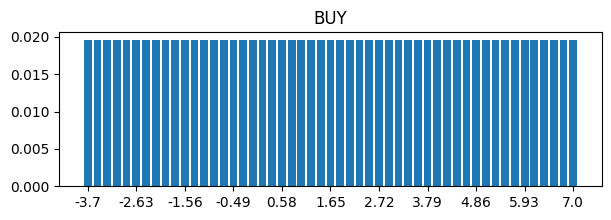

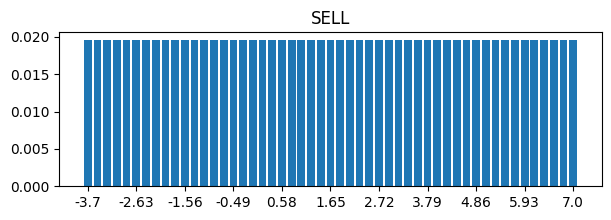

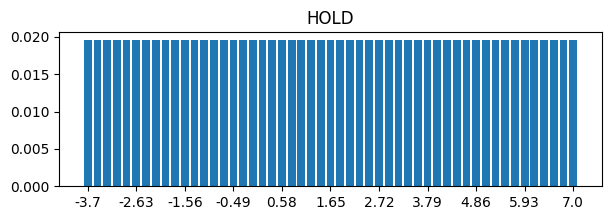

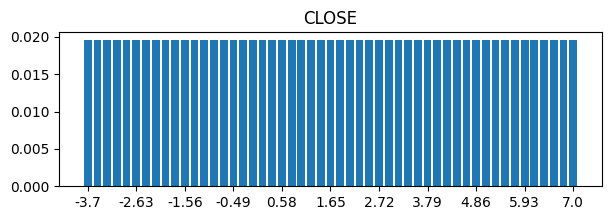

In [1530]:
from scipy.stats import entropy
import scipy
# Get the distribution
time_step = train_env.current_time_step()
action_step = C51_agent.policy.action(time_step)
#action_step = my_policy.action(time_step)
next_time_step = train_env.step(action_step.action)
state = time_step.observation
distributions = custom_network(state)[0][0]
testttt = tf.cast(distributions,tf.float32)
#softmax_distribution = tf.nn.softmax(testttt)
#entropy = -tf.reduce_sum(softmax_distribution * tf.math.log(softmax_distribution))

#the_val = testttt.numpy()
#val = scipy.stats.entropy(the_val)





def entropy_single(logits):
    #epsilon = 1e-10
    #min_value = tf.reduce_min(distribution)
    #tensor_subtracted = tf.subtract(distribution, min_value)
    #offset = tf.add(tensor_subtracted,epsilon)
    #sum_tensor = tf.reduce_sum(offset)
    #p = tf.divide(offset, sum_tensor)
    p = tf.nn.softmax(logits)
    return -tf.reduce_sum(p * tf.math.log(p))

def Entropy(Distribution):
    entropy_values = tf.map_fn(entropy_single, Distribution)
    highest_index = tf.math.argmax(entropy_values)
    return highest_index

action = ""
action_num = action_step[0][0]

def return_action(action_input):
    
    if action_input == 0:
        action = "BUY"
    elif action_input == 1:
        action = "SELL"
    elif action_input == 2:
        action = "HOLD"
    else:
        action = "CLOSE"
        
    return action


    
print("Action: " + return_action(action_num))
print("Highest Entropy: " + return_action(Entropy(distributions).numpy()))
values = np.linspace(min_q, max_q, 51)
#values = [round(value, 2) for value in values]

# Round the numbers to one decimal place and only include every other value
values = [round(value, 2) for value in values[::5]]
tf.print(state[1][0])
Names = ["BUY","SELL","HOLD","CLOSE"]
for i in range(4):
    #print(i)
    #print(entropy_single(testttt[i]).numpy())
    dist = tf.nn.softmax(testttt[i])
    
    
    plt.figure(figsize=(7,2)) 
    plt.bar(range(len(dist)), dist)
    plt.xticks(range(len(dist))[::5], values)
    plt.title(Names[i])
    #chart goes from low q to high q value
    plt.show()




In [ ]:




@tf.function
def train(agent):

    for step in tf.range(1000):
        for _ in tf.range(COLLECTION_STEPS):
        #while not time_step.is_last():
            timestamp_data(train_env, my_policy, replay_buffer)

        experience, info = next(iterator)
        train_loss = agent.train(experience).loss

        if step % EVAL_INTERVAL == 0:
            avg_reward = run_environment(evaluation_env,agent.policy)

            tf.print('Reward:',avg_reward,' Loss:',train_loss,' Epsilon:',epsilon_decay(global_step))


        #Increment the global step variable
        global_step.assign_add(1)


print("**********************************")
print("Training C51_agent")
print("**********************************")
for i in range(1000000000):
    C51_reward = train(C51_agent)
    train_checkpointer.save(global_step)

**********************************
Training C51_agent
**********************************
Reward: 4.26855659  Loss: 4.35920715  Epsilon: 0.5
Reward: -3.42829466  Loss: 3.61724424  Epsilon: 0.499
Reward: -9.57051754  Loss: 3.58243036  Epsilon: 0.498
Reward: 1.76965404  Loss: 3.53923488  Epsilon: 0.497
Reward: 1.47304046  Loss: 3.47112656  Epsilon: 0.496
Reward: -10.0784988  Loss: 3.43112946  Epsilon: 0.495
Reward: -5.56442881  Loss: 3.30224085  Epsilon: 0.494
Reward: 2.95117617  Loss: 3.37360406  Epsilon: 0.493
Reward: -2.22449064  Loss: 3.34683084  Epsilon: 0.492
Reward: -0.754348278  Loss: 3.33065081  Epsilon: 0.491
Reward: -1.79716146  Loss: 3.34093022  Epsilon: 0.49
Reward: 7.5776763  Loss: 3.31657314  Epsilon: 0.489
Reward: -0.690447927  Loss: 3.25467515  Epsilon: 0.488
Reward: -6.48557329  Loss: 3.29233503  Epsilon: 0.487
Reward: -1.99784958  Loss: 3.3029685  Epsilon: 0.486
Reward: 1.62938917  Loss: 3.14729166  Epsilon: 0.485
Reward: 2.52345443  Loss: 3.22617531  Epsilon: 0.484
Rew

In [ ]:
def compute_avg_return_print(environment, policy, num_episodes=10):

  total_return = 0.0
  for episode in range(num_episodes):
    balance_arr = []
    time_step = environment.reset()
    episode_return = 0.0
    returns = np.array([])
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      obs = time_step.observation

      balance = np.sum(env.get_balance())
      returns = env.get_balance()
      balance_arr.append(balance)
      # Print the episode number and observation at each step
      print(f"Episode {episode + 1}: Observation = {obs[1]}")

      episode_return += time_step.reward
    plt.plot(balance_arr)
    total_return += episode_return
    #print(-calculate_downside_deviation(returns,-.5))
    print(mean_of_negatives(returns))
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [ ]:
avg_return = compute_avg_return_print(evaluation_env, C51_agent.policy, 20)
print(avg_return)

In [ ]:
snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')

for stat in top_stats[:10]:
    print(stat)